# Modello CNN
Genereazione di mappe di perfusione cerebrale rCBV a partire da immagini di Risonanza Magnetica DSC utilizzando un modello CNN.

In [1]:
!pip install numpy torch torchvision torchio matplotlib torchinfo torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.8/172.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 538.1 kB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.3.4
    Uninstalling rich-13.3.4:
      Successfully uninstalled rich-13.3.4


In [2]:
# imports
import torch
import torchio as tio
import numpy as np
import os
from torchinfo import summary
import skimage #serve per elaborazione immagini (nel nostro caso usiamo per le metriche)
import torch.nn as nn #ci sono moduli per alcuni modelli neurali, regressione, convoluzione ecc
import torch.nn.functional as F #qui invece ci possono essere buoni comandi per kernel, filtraggi, max pooling e cose così
import shutil
import torchvision
from torchvision import models, transforms as tt
import matplotlib.pyplot as plt
import nibabel as nib #libreria per la gestion di file .nii
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import normalized_root_mse as nrmse
from google.colab import drive
drive.mount('/content/drive/') #Ora necessario caricare su drive le cartelle, necessario però un metodo alternativo (caricare i file dal locale) COME?

Mounted at /content/drive/


In [3]:
data_dir = '/content/drive/MyDrive/Data (prova)'  # directory della cartella "data" (già importata su drive)

# Creazione di una lista di patients_ID
patients_ID = [] 
for f in os.scandir(data_dir): # restituisce un iteratore sugli elementi presenti nella directory "data_dir"
  if f.is_dir(): # se l'elemento è una directory, allora viene aggiungo alla lista
    patients_ID.append(f.name) # riempimento della lista patients_ID con tutti i nomi delle directory che sono contenuti in data e soddisfano l'if

In [4]:
#data = '/content/drive/MyDrive/Data (prova)'  # directory
#patients_ID = []
#for f in os.scandir(data):
#  if f.is_dir():
#    patients_ID.append(f.name) # riempimento della lista patients_ID con tutti i nomi delle directory che sono contenuti in data e soddisfano l'if

In [5]:
# Creazione di una lista patients_list
patients_list = []
for current in patients_ID:
  subj_dir = data_dir +'/'+ current 
  
  #Creazione di un'istanza
  patient = tio.Subject( # creo un oggetto "Subject" per ogni paziente della lista utilizzando le immagini DSC e rCBV
      DSC = tio.ScalarImage(subj_dir + '/DSC.nii'), #.to(torch.float32), # ScalarImagine: immagine scalare 3D
      rCBV = tio.ScalarImage(subj_dir + '/DSC_ap-rCBV.nii'),  # ogni paziente contiene nome, immagine DSC e immagine rCBV
      #brain_mask = tio.LabelMap(subj_dir + '/brain_mask.nii')
      )
  
  #patient.DSC.set_data(patient.DSC.data.to(torch.float32))
  #patient.rCBV.set_data(patient.rCBV.data.to(torch.float32))
 
  patients_list.append(patient)    # aggiunta di patient alla lista patients_list


L'oggetto "patient" rappresenta un paziente specifico, contenente il nome del paziente e le immagini DSC e rCBV del paziente.

In [6]:
#Creazione Dataset
dataset = tio.SubjectsDataset(patients_list)
print('Dataset size:', len(dataset), 'patients')

Dataset size: 50 patients


In [7]:
print(dataset[0]["DSC"][tio.DATA].dtype),
print(dataset[0]["rCBV"][tio.DATA].dtype)

torch.int16
torch.int16


### Visualizzare tipo e immagine input output

## Training e Validation set

### Preparazione dei dati (trasformazioni)

In [8]:
training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.CropOrPad((120,120,80)), #Crop the images w,h,d and centre around the mask_name
    tio.Resample((2,2,2)),
    #tio.ZNormalization(masking_method='brain_mask'),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.CropOrPad((120,120,80)), #Crop the images w,h,d and centre around the mask_nam
    tio.Resample((2,2,2)),
    #tio.ZNormalization(masking_method='brain_mask'),
])


### Divisione del dataset

In [9]:
# suddivisione del dataset, in modo casuale, in dati di training (70% dei dati) e di validation (30% dei dati). #MANCA 10% PER IL TESTING!!!
training_division = 0.7   # definizione della % di dati di training
validation_division = 0.2 # definizione della % di dati di validation
#test_division = 0.1

num_patients = len(dataset) # pazienti totali
train_patients = int(training_division*num_patients)
val_patients = int(validation_division*num_patients)
test_patients = int(num_patients-(train_patients+val_patients))

# creazione dei tre sottoinsiemi 
patients_division = train_patients, val_patients, test_patients
train, val, test = torch.utils.data.random_split(patients_list, patients_division) # suddivido casualmente la lista di pazienti in tre sottoinsiemi

training_set = tio.SubjectsDataset(train, transform=training_transform)
print('train_set:', len(training_set)) # per verificare il numero di dati di training
validation_set = tio.SubjectsDataset(val, transform=validation_transform)
print('val_set:', len(validation_set)) # per verificare il numero di dati di validation
test_set = tio.SubjectsDataset(test)
print('test_set:', len(test_set))

train_set: 35
val_set: 10
test_set: 5


In [10]:
#training_set[0]["DSC"][tio.DATA].shape, training_set[0]["rCBV"][tio.DATA].shape

###Mask

In [11]:
#def masking(dataset):
#  for i in range(len(dataset)):
#    mask = dataset[i]["DSC"][tio.DATA] > 0
#   print(mask.shape)
#    dataset[i]["mask"] = mask 

In [12]:
#masking(dataset)

#dataset[0]["mask"].plot()
#dataset[1]["mask"].plot()

In [13]:
 #visualizzare info
#print(paziente_1.DSC.shape)
#mask = dataset[0]["DSC"][tio.DATA]>0
#print(mask.shape)

#print(paziente_1.DSC)
#print(paziente_1.rCBV)

##Creazione del DataLoader

In [14]:
#check num_cores disponibili
import multiprocessing
cores = multiprocessing.cpu_count() # per contare il numero di cpu che si hanno
cores

4

In [15]:
from torch.utils.data.dataloader import DataLoader
batch_size = 8 # dimensione del batch
train_loader = torch.utils.data.DataLoader(training_set, 
                                           batch_size, 
                                           shuffle = True,
                                           num_workers=cores,
                                           pin_memory=True) # shuffle = True indica che i dati vengono caricati in modo casuale
val_loader = torch.utils.data.DataLoader(validation_set, 
                                         batch_size, 
                                         shuffle = False,
                                         num_workers=cores,  #metto tanti cores quanti ne ho disponibili
                                         pin_memory=True)  # i dati vengono caricati in ordine

### Sposto il DataLoader e i dati sulla GPU

In [16]:
# Verifico che la GPU sia disponibile
torch.cuda.is_available() # Resistuisce 'True' se la GPU è accessibile

True

In [17]:
def get_default_device():
    # Se è disponibile prende la GPU, altrimenti la CPU locale
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
#def to_device(data, device):
#    # Sposta i tensori (dati) sul device stabilito
#        return data.to(device, non_blocking=True)
#    if isinstance(data, torch.Tensor): # sposto i tensori
#    elif isinstance(data, (list,tuple)): # sposto le liste o le tuple
#        return [to_device(x, device) for x in data]
#    elif isinstance(data, dict): # sposto i dizionari
#        return {k: to_device(v, device) for k, v in data.items()}
#    else:
#        return data

def to_device(data, device):
    if isinstance(data, (list,tuple)): 
      return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    # Wrapping del DataLoader per spostare i dati sul device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        # Restituisce un batch di dati spostandolo sulla GPU
        for b in self.dl: 
            yield to_device(b, self.device) if isinstance(b, torch.Tensor) else b

    def __len__(self):
        # Numero di batch
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_loader = DeviceDataLoader(train_loader, device)  # crea un DeviceDataLoader "avvolgendo" (wrapping) il train_loader
val_loader = DeviceDataLoader(val_loader, device) # idem per il val_loader

## Creazionde del modello

In [20]:
#def set_parameter_requires_grad(model, feature_extracting):
#    if feature_extracting:
#        for param in model.parameters():
#            param.requires_grad = False
#permette di congelare tutti i pesi, non vengono più "aggiustati"

In [21]:
#resnet18 = torchvision.models.resnet18(pretrained=True)

In [22]:
#print(resnet18)

In [23]:
#for param in resnet18.parameters():
#    param.requires_grad = False

In [24]:
#inizializzo e rimodello le reti dei modelli preaddestrati


In [25]:
#type(training_set[0].DSC), 
#training_set[0]["rCBV"].data #1: dice il tipo di dato che si ha #2: printa il contenuto del tensore

In [26]:
#def show_batch_DSC(data_loader):
#  for batch_idx, batch_sample in enumerate(data_loader):
#    images = batch_sample["DSC"][tio.DATA]
#    img_DSC = images[0, 0, :, :, 50] #prendo solo la prima immagine, le x e le y della 50 fetta sulle z del time frame 0.

#    # Visualizzazione delle prime 4 immagini della batch
#    plt.imshow(img_DSC, cmap="gray")
#    plt.show()    # Interrompi l'iterazione dopo la prima batch
#    break

In [27]:
#show_batch_DSC(train_loader)

In [28]:
def prepare_batch(batch, device): # estrae l'input e l'output desiderati da una singola batch di dati del loader e li restituisce come tensori PyTorch
    inputs = batch["DSC"][tio.DATA].to(device).to(torch.float32) # tensore 
    targets = batch["rCBV"][tio.DATA].to(device) # tensore
    return inputs, targets

In [29]:
from torchmetrics.functional import structural_similarity_index_measure 

In [30]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        inputs, targets = prepare_batch(batch, device)
        print(inputs.shape)
        print(targets.shape)
        out = self(inputs)  # Generate predictions
        print(out.shape)             
        loss = F.mse_loss(out, targets) # Calculate loss
        print("Fine train")
        return loss

    def validation_step(self, loader):
        inputs, targets = prepare_batch(loader, device)
        out = self(inputs)     # Generate predictions
        loss = F.mse_loss(out, targets)   # Calculate loss

        targets = targets.cpu().detach().numpy().squeeze() #converto in numpy perchè skimage lavora su tensori di questo tipo
        out = out.cpu().detach().numpy().squeeze()
      
        print(targets.shape, out.shape)

        mse_ = np.square(np.subtract(targets, out)).mean() # Calculate mean square error
        nrmse_ = nrmse(targets, out) # Calculate normalized root mean square error
        ssim_ = structural_similarity_index_measure(torch.from_numpy(targets).to(torch.float32), torch.from_numpy(out).to(torch.float32), data_range = out.max() - out.min()) # Calculate structural similarity index
        psnr_ = psnr(targets, out, data_range = out.max() - out.min()) # Calculate peak signal to noise ratio
        return {'val_loss': loss.detach(), 'mse': mse_, 'nrmse': nrmse_, 'ssim': ssim_, 'psnr':psnr_}
   
    def validation_epoch_end(self, outputs):
      batch_losses = [x['val_loss'] for x in outputs]
      epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
      batch_mses = [x['mse'] for x in outputs]
      epoch_mse = np.mean(batch_mses)   # Combine mses
      batch_nrmses = [x['nrmse'] for x in outputs]
      epoch_nrmse = np.mean(batch_nrmses)  # Combine nrmses
      batch_ssims = [x['ssim'] for x in outputs]
      epoch_ssim = np.mean(batch_ssims)   # Combine ssims
      batch_psnrs = [x['psnr'] for x in outputs]
      epoch_psnr = np.mean(batch_psnrs) # Combine psnrs
      return {'val_loss': epoch_loss.item(), 'mse': epoch_mse.item(), 'nrmse': epoch_nrmse.item(), 'ssim': epoch_ssim.item(), 'psnr':epoch_psnr.item()}
    
    def epoch_end(self, epoch, result):
      print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, mse: {:.4f}, nrmse: {:.4f}, ssim: {:.4f}, psnr: {:.4f}".format(epoch+1, result['train_loss'], result['val_loss'], result['mse'], result['nrmse'], result['ssim'], result['psnr']))
  

In [31]:
import torch.nn as nn
import torchvision.models as models
class CustomResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.conv11 = nn.Sequential( #input 3 x 45 x 256 x 256 x 16
            nn.Conv3d(45,32, kernel_size=(1,1,1), stride=1), #output 3 x 32 x 256 x 256 x 16 #32x60x60x40
            nn.BatchNorm3d(32, eps=1e-03, momentum=0.1), #output 3 x 32 x x 256 x 256 x 16
            nn.LeakyReLU()) #output 3 x 32 x 256 x 256 x 16
        self.conv12 = nn.Sequential(
            nn.Conv3d(32,32, kernel_size=(1,1,1), stride=1), #output 3 x 32 x 256 x 256 x 16
            nn.BatchNorm3d(32, eps=1e-03, momentum=0.1), #output 3 x 32 x 256 x 256 x 16
            nn.LeakyReLU()) #output 3 x 32 x 256 x 256 x 16
        self.pool1 = nn.MaxPool3d(kernel_size=(2,2,1)) #output 3 x 32 x 128 x 128 x 16 ##3 x 32 x 30 x 30 x 40
        
        self.conv21 = nn.Sequential(
            nn.Conv3d(32,64, kernel_size=(5,5,2), stride=1), #output 3 x 64 x 124 x 124 x 15 ##3x64x26x26x39
            nn.BatchNorm3d(64, eps=1e-03, momentum=0.1), #output 3 x 64 x 124 x 124 x 15 
            nn.LeakyReLU()) #output 3 x 64 x 124 x 124 x 15
        self.conv22 = nn.Sequential(
            nn.Conv3d(64,64, kernel_size=(5,5,2), stride=1), #output 3 x 64 x 120 x 120 x 14 ##3 x 64 x 22 x 22 x 38
            nn.BatchNorm3d(64, eps=1e-03, momentum=0.1), #output 3 x 64 x 120 x 120 x 14
            nn.LeakyReLU()) #output 3 x 64 x 120 x 120 x 14
        self.pool2 = nn.MaxPool3d(kernel_size=(2,2,1)) #output 3 x 64 x 60 x 60 x 14 ##3 x 64 x 11 x 11 x 38
        
        self.conv31 = nn.Sequential(
            nn.Conv3d(64,128, kernel_size=(5,5,2), stride=1), #output 3 x 128 x 56 x 56 x 13 ##3 x 128 x 7 x 7 x 37
            nn.BatchNorm3d(128, eps=1e-03, momentum=0.1), #output 3 x 128 x 56 x 56 x 13
            nn.LeakyReLU()) #output 3 x 128 x 56 x 56 x 13
        self.conv32 = nn.Sequential(
            nn.Conv3d(128,128, kernel_size=(5,5,2), stride=1), #output 3 x 128 x 52 x 52 x 12 ##3x128x3x3x36
            nn.BatchNorm3d(128, eps=1e-03, momentum=0.1), #output 3 x 128 x 52 x 52 x 12
            nn.LeakyReLU()) #output 3 x 128 x 52 x 52 x 12#################
        
        self.Aconv1 = self.deconv1 = nn.ConvTranspose3d(128, 64, kernel_size=(8,8,5))

        self.Aconv2 = nn.Sequential(
            nn.Conv3d(in_channels=64, out_channels=32, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU())

        self.deconv4 = nn.Sequential(
                nn.Conv3d(in_channels=32, out_channels=16, kernel_size=(3, 3, 3), stride=1, padding=1),
                nn.BatchNorm3d(16),
                nn.LeakyReLU())
        #self.conv51 = nn.Sequential(
        #    nn.Conv3d(in_channels=128, out_channels=64, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
        #    nn.BatchNorm3d(64),
        #    nn.LeakyReLU())
        self.conv52 = nn.ConvTranspose3d(16, 8, kernel_size=(31,31,1))
        self.deconv61 = nn.ConvTranspose3d(8, 4, kernel_size=(21,21,1))
        self.deconv62 = nn.ConvTranspose3d(4, 1, kernel_size=(1,1,1))
        
        
    def forward(self,x):
        conv11 = self.conv11(x)
        print(conv11.shape)
        conv12 = self.conv12(conv11)
        print(conv12.shape)
        pool1 = self.pool1(conv12)
        print(pool1.shape)
        conv21 = self.conv21(pool1)
        print(conv21.shape)
        conv22 = self.conv22(conv21)
        print(conv22.shape)
        pool2 = self.pool2(conv22)
        print(pool2.shape)
        
        conv31 = self.conv31(pool2)
        print(conv31.shape)
        conv32 = self.conv32(conv31)
        print(conv32.shape)
        Aconv1 = self.Aconv1(conv32)   
        print(Aconv1.shape)     
        Aconv2 = self.Aconv2(Aconv1)
        print(Aconv2.shape)
        
        deconv4 = self.deconv4(Aconv2)
        print(deconv4.shape)
        #deconv_concat4 = torch.cat(deconv4)
        
        #conv51 = self.conv51(deconv4)
        conv52 = self.conv52(deconv4)
        print(conv52.shape)
        conv62 = self.deconv61(conv52)
        out = self.deconv62(conv62) 
        #deconv_concat3 = torch.cat((conv32,deconv3),1)
        
        
    
        return out

In [32]:
model = CustomResNet()#.to('cuda')

# sposto il modello sulla GPU
model = to_device(model, device)
#print(model) 
#print('Modello su dispositivo:', next(model.parameters()).device)

## Training del modello

In [33]:
# definisco una classe per salvare il modello durante il training. 
# se il valore della val_loss corrente è minore del precedente, allora salvo lo stato del modello

class SaveBestModel: 
  def __init__(
      self, best_valid_loss = float('inf')
  ):
      self.best_valid_loss = best_valid_loss

  def __call__(
      self, current_valid_loss,
      epoch, model, optimizer, criterion, path_name #, scheduler
  ): 
      if current_valid_loss < self.best_valid_loss: 
        self.best_valid_loss = current_valid_loss
        print(f"\nBest validation loss: {self.best_valid_loss}")
        print(f"\nSaving best model for epoch: {epoch+1}\n")
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, path_name+'.pth')


In [34]:
@torch.no_grad() #l'utilizzo di @torch.no_grad() all'interno della funzione evaluate() ha senso perché consente di disabilitare il calcolo del gradiente durante la fase di valutazione del modello, migliorando l'efficienza del processo di valutazione.

def evaluate(model, val_loader):
  # with torch.no_grad():
    model.eval()
    print("Evaluate 1 fatto")
    outputs = [model.validation_step(batch) for batch in val_loader]
    print("Evaluate 2 fatto")
    return model.validation_epoch_end(outputs)

#def get_lr(optimizer):
#    for param_group in optimizer.param_groups:
#        return param_group['lr']

#def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
#                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
#    torch.cuda.empty_cache()
#    history = []
#    
#    # Set up cutom optimizer with weight decay
#    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
#    # Set up one-cycle learning rate scheduler
#    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
#                                                steps_per_epoch=len(train_loader))
#    
#    for epoch in range(epochs):
#        
#        #strt_time = time.time()
#        
#        # Training Phase 
#        model.train()
#        train_losses = []
#        lrs = []
#        for batch in train_loader:
#
#            
#            loss = model.training_step(batch)
#            loss.to(torch.float32)
#            train_losses.append(loss)
#            loss.backward()
#            
#            # Gradient clipping
#            if grad_clip: 
#                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
#            
#            optimizer.step()
#            optimizer.zero_grad()
#            
#            # Record & update learning rate
#            lrs.append(get_lr(optimizer))
#            scheduler.step()
#            
#        #end_time = time.time()
#        #tot_time = end_time-strt_time
#        #print('Epoch training time:', tot_time, 'sec')
#            
#        # Validation phase 
#        result = evaluate(model, val_loader)
#        result['train_loss'] = torch.stack(train_losses).mean().item()
#        result['lrs'] = lrs
#        model.epoch_end(epoch, result)
#        history.append(result)
#        
#        #save_best_model(
#        #result['val_loss'], epoch, model, optimizer, scheduler, criterion, path_name
#    #)
#    return history

def fit(epochs, lr, model, train_loader, val_loader, opt_func, path_name):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=0.1)
    for epoch in range(epochs):

        # Training Phase 
        print("Inizio del train")
        model.train()
        train_losses = []
        for batch_idx, batch in enumerate(train_loader):
            loss = model.training_step(batch).detach().requires_grad_(True) #uso detach per provare a creare un nuovo tensore che possa fare il gradient descend
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        print("Inizio fase di validazione")
        result = evaluate(model, val_loader)
        print("Evaluate fatto")
        result['train_loss'] = torch.stack(train_losses).mean().item()
        print("2 fatto")
        model.epoch_end(epoch, result)
        print("3 fatto")
        history.append(result)

        save_best_model(
            result['val_loss'], epoch, model, optimizer, criterion, path_name
        )

    return history

In [35]:
num_epochs = 10
opt_func = torch.optim.Adam
lr=0.01

In [36]:
print(model)

CustomResNet(
  (conv11): Sequential(
    (0): Conv3d(45, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): BatchNorm3d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv12): Sequential(
    (0): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): BatchNorm3d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (pool1): MaxPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv21): Sequential(
    (0): Conv3d(32, 64, kernel_size=(5, 5, 2), stride=(1, 1, 1))
    (1): BatchNorm3d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv22): Sequential(
    (0): Conv3d(64, 64, kernel_size=(5, 5, 2), stride=(1, 1, 1))
    (1): BatchNorm3d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)


In [37]:
#summary(model.cuda(), input_size=(2,45,60,60,40))


In [38]:
evaluate(model, val_loader)

Evaluate 1 fatto
torch.Size([8, 32, 60, 60, 40])
torch.Size([8, 32, 60, 60, 40])
torch.Size([8, 32, 30, 30, 40])
torch.Size([8, 64, 26, 26, 39])
torch.Size([8, 64, 22, 22, 38])
torch.Size([8, 64, 11, 11, 38])
torch.Size([8, 128, 7, 7, 37])
torch.Size([8, 128, 3, 3, 36])
torch.Size([8, 64, 10, 10, 40])
torch.Size([8, 32, 10, 10, 40])
torch.Size([8, 16, 10, 10, 40])
torch.Size([8, 8, 40, 40, 40])
(8, 60, 60, 40) (8, 60, 60, 40)
torch.Size([2, 32, 60, 60, 40])
torch.Size([2, 32, 60, 60, 40])
torch.Size([2, 32, 30, 30, 40])
torch.Size([2, 64, 26, 26, 39])
torch.Size([2, 64, 22, 22, 38])
torch.Size([2, 64, 11, 11, 38])
torch.Size([2, 128, 7, 7, 37])
torch.Size([2, 128, 3, 3, 36])
torch.Size([2, 64, 10, 10, 40])
torch.Size([2, 32, 10, 10, 40])
torch.Size([2, 16, 10, 10, 40])
torch.Size([2, 8, 40, 40, 40])
(2, 60, 60, 40) (2, 60, 60, 40)
Evaluate 2 fatto


{'val_loss': 1726.833740234375,
 'mse': 1726.83349609375,
 'nrmse': 1.0150902771617083,
 'ssim': -2.0282840296204085e-07,
 'psnr': -55.49750017373708}

In [39]:
#history1 = []
#history1 += fit_one_cycle(40, 0.01, model, train_loader, val_loader, weight_decay=0.01, grad_clip=20, opt_func=torch.optim.Adam)

In [40]:
# loss function
criterion = nn.MSELoss()

# optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) #weight decay = 0.1

# scheduler (none)

# initialize SaveBestModel class
save_best_model = SaveBestModel()


In [41]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func, path_name='ResNet_best_model_train')

Inizio del train
torch.Size([8, 45, 60, 60, 40])
torch.Size([8, 1, 60, 60, 40])
torch.Size([8, 32, 60, 60, 40])
torch.Size([8, 32, 60, 60, 40])
torch.Size([8, 32, 30, 30, 40])
torch.Size([8, 64, 26, 26, 39])
torch.Size([8, 64, 22, 22, 38])
torch.Size([8, 64, 11, 11, 38])
torch.Size([8, 128, 7, 7, 37])
torch.Size([8, 128, 3, 3, 36])
torch.Size([8, 64, 10, 10, 40])
torch.Size([8, 32, 10, 10, 40])
torch.Size([8, 16, 10, 10, 40])
torch.Size([8, 8, 40, 40, 40])
torch.Size([8, 1, 60, 60, 40])
Fine train
torch.Size([8, 45, 60, 60, 40])
torch.Size([8, 1, 60, 60, 40])
torch.Size([8, 32, 60, 60, 40])
torch.Size([8, 32, 60, 60, 40])
torch.Size([8, 32, 30, 30, 40])
torch.Size([8, 64, 26, 26, 39])
torch.Size([8, 64, 22, 22, 38])
torch.Size([8, 64, 11, 11, 38])
torch.Size([8, 128, 7, 7, 37])
torch.Size([8, 128, 3, 3, 36])
torch.Size([8, 64, 10, 10, 40])
torch.Size([8, 32, 10, 10, 40])
torch.Size([8, 16, 10, 10, 40])
torch.Size([8, 8, 40, 40, 40])
torch.Size([8, 1, 60, 60, 40])
Fine train
torch.Size(

In [42]:
def plot_val_loss(history):
    val_loss = [x['val_loss'] for x in history]
    plt.plot(val_loss, '-x')
    plt.xlabel('epoch')
    plt.ylabel('val_loss')
    plt.title('val_loss vs. No. of epochs')
    plt.show();

In [43]:
def plot_train_loss(history):
    train_loss = [x['train_loss'] for x in history]
    plt.plot(train_loss, '-x')
    plt.xlabel('epoch')
    plt.ylabel('train_loss')
    plt.title('train_loss vs. No. of epochs')
    plt.show();

In [44]:
def plot_MSE(history):
    mse = [x['mse'] for x in history]
    plt.plot(mse, '-x')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.title('MSE vs. No. of epochs')
    plt.show();

In [45]:
def plot_NRMSE(history):
    nrmse = [x['nrmse'] for x in history]
    plt.plot(nrmse, '-x')
    plt.xlabel('epoch')
    plt.ylabel('NRMSE')
    plt.title('NRMSE vs. No. of epochs')
    plt.show();

In [46]:
def plot_PSNR(history):
    psnr = [x['psnr'] for x in history]
    plt.plot(psnr, '-x')
    plt.xlabel('epoch')
    plt.ylabel('PSNR')
    plt.title('PSNR vs. No. of epochs')
    plt.show();

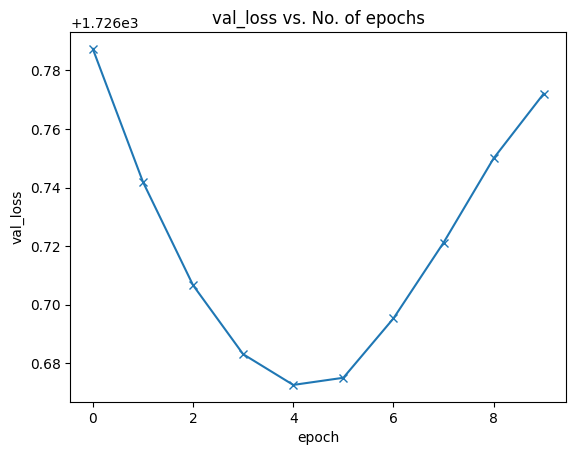

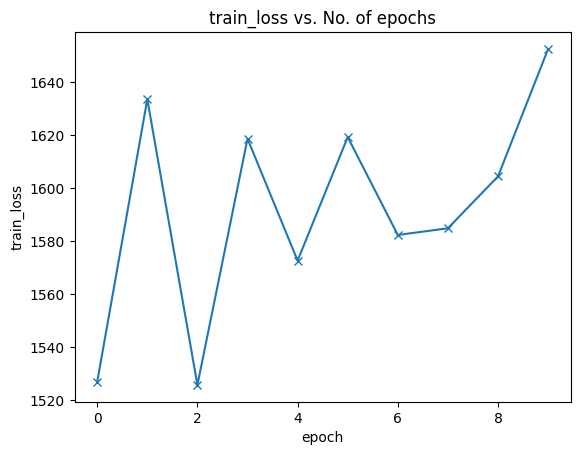

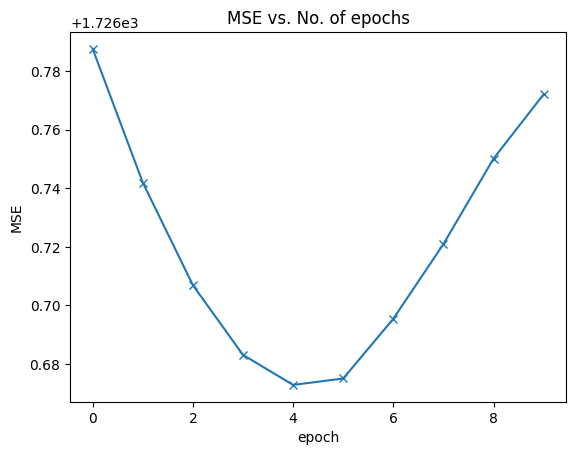

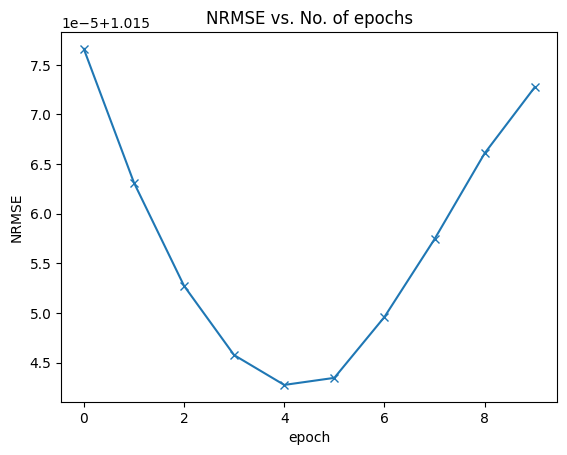

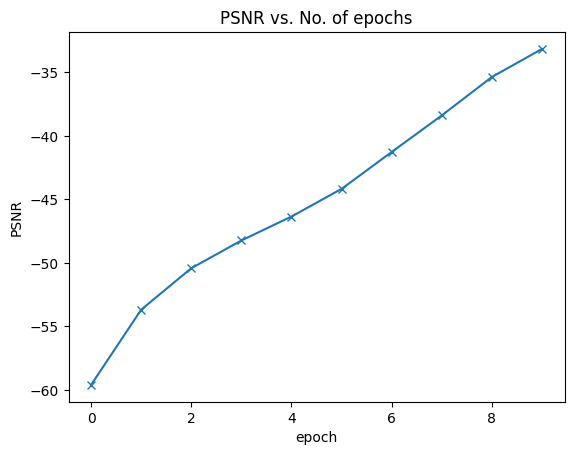

(None, None, None, None, None)

In [47]:
plot_val_loss(history), plot_train_loss(history), plot_MSE(history), plot_NRMSE(history), plot_PSNR(history)

## Testing del modello

In [48]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img  #.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    #

In [49]:
#visualizzare un'immagine specifica
training_set[0].rCBV
#nii_array = nii_image.numpy() #bisogna trasformare l'immagin ein vettore con il comando numpy()
#plt.imshow(nii_array[1, :, :, 50], cmap='gray') #time_frame,x,y,z
#plt.show()
#training_set[0].DSC, training_set[0].rCBV

ScalarImage(shape: (1, 60, 60, 40); spacing: (2.00, 2.00, 2.00); orientation: RAS+; dtype: torch.ShortTensor; memory: 281.2 KiB)

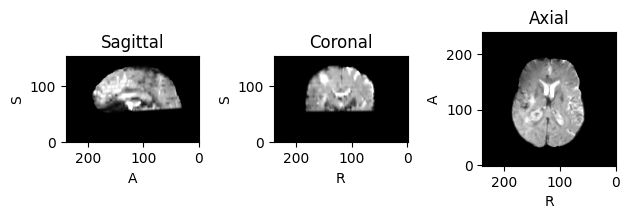

In [50]:
dataset[0]["DSC"].plot()

torch.Size([1, 240, 240, 155])


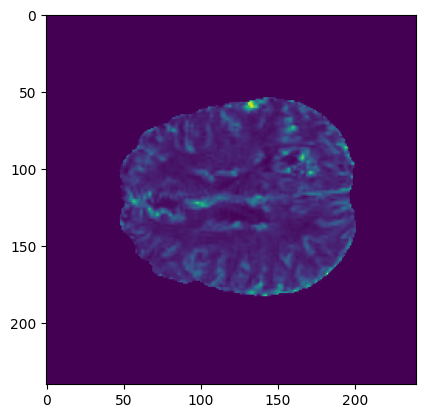

In [51]:
xb = dataset[0]["rCBV"][tio.DATA]
print(xb.shape)
plt.imshow(xb[0, ...,90])

torch.Size([1, 32, 60, 60, 40])
torch.Size([1, 32, 60, 60, 40])
torch.Size([1, 32, 30, 30, 40])
torch.Size([1, 64, 26, 26, 39])
torch.Size([1, 64, 22, 22, 38])
torch.Size([1, 64, 11, 11, 38])
torch.Size([1, 128, 7, 7, 37])
torch.Size([1, 128, 3, 3, 36])
torch.Size([1, 64, 10, 10, 40])
torch.Size([1, 32, 10, 10, 40])
torch.Size([1, 16, 10, 10, 40])
torch.Size([1, 8, 40, 40, 40])


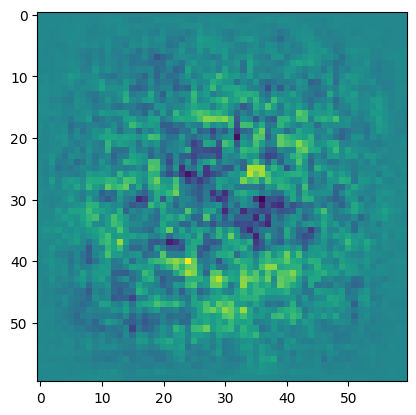

In [52]:
import random
subject = random.choice(validation_set)

input_tensor = subject['DSC'][tio.DATA].to(device)
input_tensor.shape

model.eval()

with torch.no_grad():
    pred = model(input_tensor.unsqueeze(0).to(torch.float32)) 
    plt.imshow(pred[0,0, ..., 30].cpu())

In [53]:
pred.shape
input_tensor.shape

torch.Size([45, 60, 60, 40])

In [54]:
print(dataset[0]["DSC"][tio.DATA].shape)
yb=dataset[0]["DSC"][tio.DATA].unsqueeze(dim=0)
print(yb.shape)
yb=model(dataset[0]["DSC"][tio.DATA].unsqueeze(dim=0).cuda().to(torch.float32))
plt.imshow(yb.detach().numpy()[0,0, :, :, 50], cmap='gray')

torch.Size([45, 240, 240, 155])
torch.Size([1, 45, 240, 240, 155])
torch.Size([1, 32, 240, 240, 155])
torch.Size([1, 32, 240, 240, 155])
torch.Size([1, 32, 120, 120, 155])
torch.Size([1, 64, 116, 116, 154])
torch.Size([1, 64, 112, 112, 153])
torch.Size([1, 64, 56, 56, 153])
torch.Size([1, 128, 52, 52, 152])
torch.Size([1, 128, 48, 48, 151])
torch.Size([1, 64, 55, 55, 155])
torch.Size([1, 32, 55, 55, 155])
torch.Size([1, 16, 55, 55, 155])
torch.Size([1, 8, 85, 85, 155])


TypeError: ignored

In [ ]:
torch.cuda.empty_cache()
device = torch.device("cpu")
input_tensor = dataset[0]["DSC"][tio.DATA].cpu().to(torch.float32).unsqueeze(dim=0)#.to(model.device).to(torch.float32)
yb = model(input_tensor)
plt.imshow(yb.detach().cpu().numpy()[0, 0, :, :, 80], cmap='gray')

Funziona, èquella presentata al secondo round. Le metriche ottenute non sono buone. Va migliorato il modello.